In [1]:
import os

In [2]:
%pwd

'c:\\Users\\Portable\\OneDrive\\Desktop\\MLOps School Project\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\Portable\\OneDrive\\Desktop\\MLOps School Project'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv(r"data\raw\IBM_stock_data.csv")

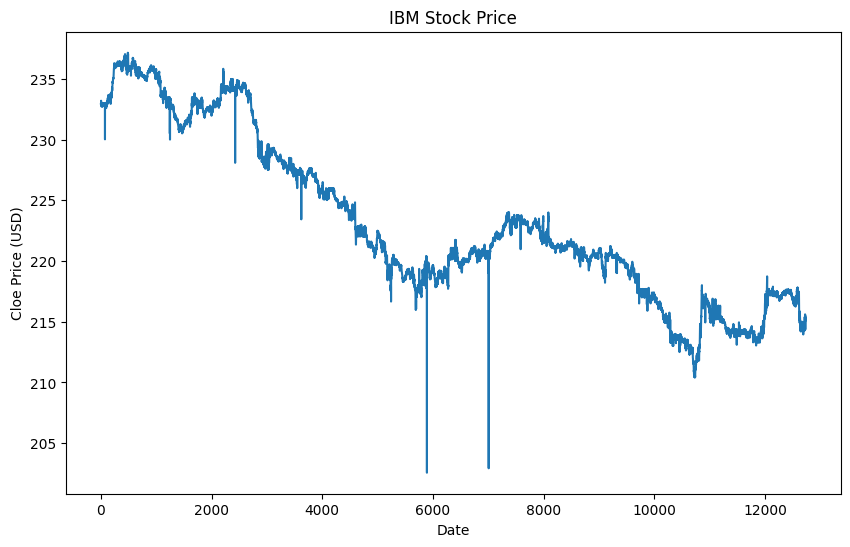

In [9]:
df["close"].plot(figsize=(10, 6))
plt.title(f'IBM Stock Price')
plt.xlabel('Date')
plt.ylabel('Cloe Price (USD)')
plt.show()

Simple Moving Average

# 20-period simple moving average
df['SMA_20'] = df['close'].rolling(window=20).mean()

df[['SMA_20', 'close']].head(21)

In [10]:
# Plot close price and moving average
df[['close', 'SMA_20']].plot(figsize=(10, 6))
plt.title('Stock Price with 20-Period SMA')
plt.show()

KeyError: "['SMA_20'] not in index"

Exponential Moving Average

In [ ]:
# 20-period exponential moving average
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

# Plot close price and EMA
df[['close', 'EMA_20']].plot(figsize=(10, 6))
plt.title('Stock Price with 20-Period EMA')
plt.show()

In [4]:
from StockPricePrediction.components.data_ingestion import DataIngestion
from StockPricePrediction.components.data_preprocessing import DataPreprocessing

ModuleNotFoundError: No module named 'StockPricePrediction'

In [2]:
import os

In [3]:
%pwd

'c:\\Users\\Portable\\OneDrive\\Desktop\\Automated-Stock-Price-Prediction-Pipeline-A-Complete-MLOps-Lifecycle\\research'

In [4]:
os.chdir("../")

In [5]:
%pwd

'c:\\Users\\Portable\\OneDrive\\Desktop\\Automated-Stock-Price-Prediction-Pipeline-A-Complete-MLOps-Lifecycle'

In [6]:
import pandas as pd
from src.StockPricePrediction import logger
from src.StockPricePrediction.entity.config_entity import DataPreprocessingConfig

In [20]:
from dataclasses import dataclass
from pathlib import Path

In [21]:
@dataclass(frozen=True)
class DataPreprocessingConfig:
    input_csv_file: Path
    output_dir: Path
    sma_window: str
    ema_window: str

In [22]:

from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()  


# Load environment variables
class ConfigurationManager:
    def __init__(self, config_filepath: Path):
        self.config = read_yaml(config_filepath)
    
    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config['data_collection']  # Accessing data_collection from config.yaml
        
        # Create DataIngestionConfig using values from config.yaml
        data_ingestion_config = DataIngestionConfig(
            symbol=self.config['data_collection']['stock_symbols'],  # Accessing stock_symbols directly
            interval=self.config['data_collection']['interval'],  # Default value, you can modify it in your yaml if needed
            outputsize=self.config['data_collection']['outputsize'],  # Default value, can also be configurable
            api_key=os.getenv('ALPHA_VANTAGE_API_KEY'),  # Assuming this is set in your .env file
            base_url=config['api_endpoint'],  # Use api_endpoint from the yaml
            output_dir=Path(self.config['data_paths']['raw_data'])  # Adjusted to save in the raw data directory
        )
        
        # Ensure the output directory exists
        create_directories([data_ingestion_config.output_dir])
        
        return data_ingestion_config
    
    def get_data_preprocessing_config(self) -> DataPreprocessingConfig:
        config = self.config['preprocessing']
        
        # Create DataPreprocessingConfig using values from config.yaml 
        data_preprocessing_config = DataPreprocessingConfig(
            input_csv_file=Path(self.config['data_paths']['raw_data']),
            ema_window=self.config['preprocessing']['ema_window'],
            sma_window=self.config['preprocessing']['sma_window'],
            output_dir=Path(self.config['data_paths']['processed_data']),
        )
        
        create_directories([data_preprocessing_config.output_dir])
        
        return data_preprocessing_config

In [30]:
class DataPreprocessing:
    def __init__(self, config: DataPreprocessingConfig):
        self.config = config

    def load_data(self):
        try:
            df = pd.read_csv(self.config.input_csv_file / "IBM_stock_data.csv")
            logger.info(f"Data loaded from {self.config.input_csv_file}")
            return df
        except Exception as e:
            logger.error(f"Error loading data: {e}")
            return None

    def apply_transformations(self, df):
        try:
            if 'Unnamed: 0' in df.columns:
                df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
                logger.info("Renamed 'Unnamed: 0' to 'date' and set as index")
            
            # Z-score normalization
            df['close_normalized'] = (df['close'] - df['close'].mean()) / df['close'].std()
            
            
            # 20-period SMA and EMA
            df['SMA_20'] = df['close'].rolling(window=self.config.sma_window).mean()
            df['EMA_20'] = df['close'].ewm(span=self.config.ema_window, adjust=False).mean()
            
            # Lagged values
            df['close_lag1'] = df['close'].shift(1)
            df['close_lag3'] = df['close'].shift(3)
            
            # Filling missing values
            df['SMA_20'] = df['SMA_20'].interpolate(method='linear')
            df['close_lag1'] = df['close_lag1'].fillna(df['SMA_20'].mean())
            df['close_lag3'] = df['close_lag3'].fillna(df['SMA_20'].mean())
            

            
            logger.info("Applied transformations to data")
            return df
        except Exception as e:
            logger.error(f"Error applying transformations: {e}")
            return None

    def save_processed_data(self, df):
        try:
            os.makedirs(self.config.output_dir, exist_ok=True)
            processed_csv_path = self.config.output_dir / "processed_stock_data.csv"
            
            df.to_csv(processed_csv_path)
            
            logger.info(f"Processed data saved to {processed_csv_path}")
            return processed_csv_path
        except Exception as e:
            logger.error(f"Error saving processed data: {e}")
            return None

    def preprocess(self):
        df = self.load_data()
        if df is not None:
            df = self.apply_transformations(df)
            if df is not None:
                self.save_processed_data(df)


In [31]:
from src.StockPricePrediction.constants import *

config_manager = ConfigurationManager(config_filepath=CONFIG_FILE_PATH)
data_preprocessing_config = config_manager.get_data_preprocessing_config()

data_preprocessing = DataPreprocessing(data_preprocessing_config)
data_preprocessing.preprocess()

[2024-11-22 15:37:13,454: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-11-22 15:37:13,455: INFO: common: created directory at: data\processed]
[2024-11-22 15:37:13,473: INFO: 1201523681: Data loaded from data\raw]
[2024-11-22 15:37:13,484: INFO: 1201523681: Renamed 'Unnamed: 0' to 'date' and set as index]
[2024-11-22 15:37:13,490: INFO: 1201523681: Applied transformations to data]
[2024-11-22 15:37:13,629: INFO: 1201523681: Processed data saved to data\processed\processed_stock_data.csv]


In [17]:
preprocessing.load_data()

[2024-11-22 15:24:54,506: ERROR: 2956780545: Error loading data: type object 'DataPreprocessingConfig' has no attribute 'input_csv_file']
